# Aumento da produção de soja no Cerrado entre 2012 e 2021.

### # Importando módulos

In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as cx
from matplotlib.colorbar import ColorbarBase
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Parte I: Importando base de dados

In [3]:
meso_soja_2012 = pd.read_excel('dados/meso_2012.xlsx')
meso_soja_2021 = pd.read_excel('dados/meso_2021.xlsx')
meso = gpd.read_file('dados/BR_Mesorregioes_2022.shp')
cerrado = gpd.read_file('dados/CERRADO.shp')

In [4]:
mun_soja_2012 = pd.read_excel('dados/mun_2012.xlsx')
mun_soja_2021 = pd.read_excel('dados/mun_2021.xlsx')
mun = gpd.read_file('dados/BR_Municipios_2022.shp')

In [5]:
serie_temporal = pd.read_excel('dados/serie_temporal.xlsx')

## Parte II: Tratando e entendendo base de dados

In [6]:
cerrado.crs = CRS.from_epsg(4674)
meso.crs = CRS.from_epsg(4674)
mun.crs = CRS.from_epsg(4674)

In [7]:
meso.rename(columns={'CD_MESO': 'Cód.'}, inplace=True)
mun.rename(columns={'CD_MUN': 'Cód.'}, inplace=True)

In [8]:
meso['Cód.'] = pd.to_numeric(meso['Cód.'], errors='coerce').astype(int)
mun['Cód.'] = pd.to_numeric(mun['Cód.'], errors='coerce').astype(int)

In [9]:
mun.shape

(5572, 5)

In [10]:
mun.head()

,Cód.,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3..."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5..."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1..."


In [11]:
meso.shape

(139, 5)

In [12]:
meso.head()

,Cód.,NM_MESO,SIGLA_UF,AREA_KM2,geometry
0,1101,Madeira-Guaporé,RO,106451.296,"POLYGON ((-63.68476 -12.45306, -63.68567 -12.4..."
1,1102,Leste Rondoniense,RO,131302.876,"POLYGON ((-62.41771 -13.11894, -62.41902 -13.1..."
2,1201,Vale do Juruá,AC,85452.353,"POLYGON ((-73.12803 -8.77124, -73.12998 -8.769..."
3,1202,Vale do Acre,AC,78721.076,"POLYGON ((-67.97684 -9.35273, -67.88121 -9.396..."
4,1301,Norte Amazonense,AM,404888.525,"POLYGON ((-66.00136 -2.14483, -66.01132 -2.141..."


In [13]:
meso = meso.drop([122, 123])

In [14]:
mun = mun.drop([258, 3180, 3221, 3249, 3419, 3500, 3812, 4606, 4607])

In [15]:
meso_soja = pd.merge(meso, meso_soja_2012, on='Cód.')
meso_soja = pd.merge(meso_soja, meso_soja_2021, on='Cód.')

In [16]:
mun_soja = pd.merge(mun, mun_soja_2012, on='Cód.')
mun_soja = pd.merge(mun_soja, mun_soja_2021, on='Cód.')

In [17]:
serie_temporal_anual = pd.merge(mun, serie_temporal, on='Cód.')

In [18]:
meso_soja['Soja_3'].describe()

count    1.370000e+02
mean     1.831428e+05
std      5.300225e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.500000e+03
75%      1.306380e+05
max      4.607583e+06
Name: Soja_3, dtype: float64

In [19]:
meso_soja['Soja_4'].describe()

count    1.370000e+02
mean     2.860273e+05
std      7.306287e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.826800e+04
75%      2.966850e+05
max      6.509154e+06
Name: Soja_4, dtype: float64

## Parte III: Analisando os dados

### # Criando função para plotar mapa coroplético personalizado 

In [39]:
def plotar_mapa_cloropletico_soja_cerrado(coluna, titulo_periodo):

    # Definindo as cores e os limites para o mapa coroplético
    cores = ['green', 'lightgreen', 'yellow', 'orange', 'red', 'maroon', 'black']
    limites = [0, 0.003, 0.007, 0.028, 0.142, 0.714, 1]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(limites, cores)))

    # Plotando o mapa coroplético
    ax = meso_soja.plot(column=coluna, 
                     cmap=cmap, 
                     edgecolor='white',
                     linestyle='solid',
                     linewidth=0.1,
                     vmin=0, vmax=7000000)

    # Plotando o limite do Cerrado
    ax_2 = cerrado.plot(ax=ax, color='None', edgecolor='blue', linestyle='dashed', linewidth=1)

    # Adicionando a barra lateral de escala
    cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.03, 0.7])
    cbar = ColorbarBase(cbar_ax, cmap=cmap, boundaries=limites, ticks=limites, orientation='vertical')
    cbar.ax.tick_params(labelsize=8)

    # Personalizando os rótulos da barra de cores
    rotulos_barra = ['0', '20.000', '50.000','200.000','1.000.000','5.000.000','7.000.000']
    cbar.set_ticklabels(rotulos_barra)

    # Definindo título da barra de cores
    cbar.set_label('Produção de Soja em hectares (ha)')

    # Ajustando o espaçamento entre a barra de cores e o plot
    plt.subplots_adjust(right=0.8)

    # Definindo título e configurações de visualização 
    ax.set_title('Produção de Soja no Cerrado' + '\n', fontsize=13, loc='left', weight='bold')
    plt.suptitle(titulo_periodo, fontsize=12, y=0.925, x=0.31, color='grey')
    cx.add_basemap(ax, crs=meso_soja.crs, attribution=False, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

    # Definindo a legenda para o Cerrado
    legenda_etiquetas_cerrado = ['Cerrado']
    legenda_cerrado = [plt.Line2D([0], [0], color='blue', linestyle='dashed', linewidth=1)]
    legenda = legenda_cerrado + legenda_etiquetas_cerrado
    ax.legend(legenda, legenda_etiquetas_cerrado, loc='upper right', frameon=True, facecolor='white')

    # Ajustando zoom no Cerrado
    xmin, xmax = -62, -40
    ymin, ymax = -25, 0
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')

    # Exibindo o mapa coroplético
    plt.show()

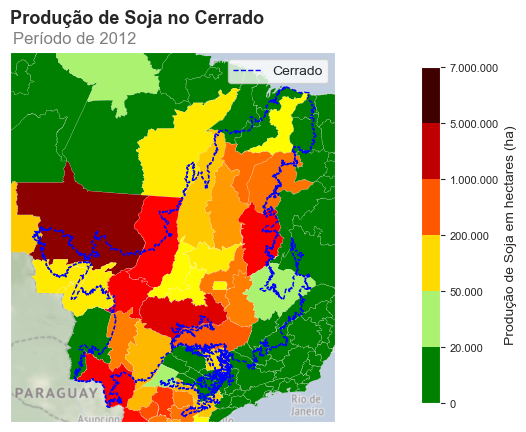

In [40]:
plotar_mapa_cloropletico_soja_cerrado('Soja_3', 'Período de 2012')

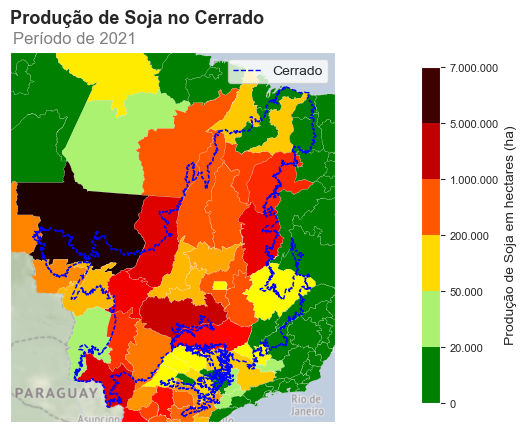

In [41]:
plotar_mapa_cloropletico_soja_cerrado('Soja_4', 'Período de 2021')

### # Bioma do cerrado sobreposto sobre os municípios brasileiros. 

In [23]:
mun_soja.head()

,Cód.,NM_MUN,SIGLA_UF,AREA_KM2,geometry,Município_x,Soja_5,Município_y,Soja_6
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...",Alta Floresta D'Oeste (RO),0,Alta Floresta D'Oeste (RO),1072
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...",Ariquemes (RO),1642,Ariquemes (RO),6979
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...",Cabixi (RO),11700,Cabixi (RO),27705
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...",Cacoal (RO),0,Cacoal (RO),2160
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1...",Cerejeiras (RO),22800,Cerejeiras (RO),36430


<AxesSubplot:>

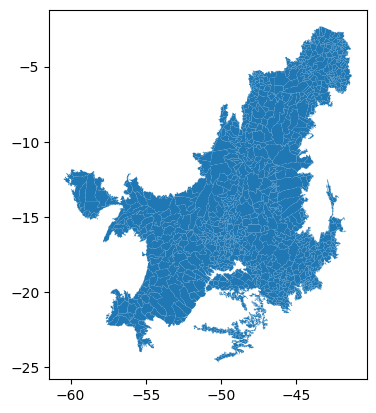

In [24]:
sobreposicao_mun_cerr = gpd.overlay(mun_soja, cerrado, how='intersection')
sobreposicao_mun_cerr.plot(linewidth=0.1)

In [25]:
ha_soja_cerrado_2012 = sobreposicao_mun_cerr['Soja_5'].sum()
ha_soja_cerrado_2012

14972254

In [26]:
ha_soja_cerrado_2021 = sobreposicao_mun_cerr['Soja_6'].sum()
ha_soja_cerrado_2021

23411119

In [27]:
area_cerrad_ha = cerrado['area_ha'][0]
area_cerrad_ha

198456796.55198

In [28]:
ha_soja_cerrado_2012 = sobreposicao_mun_cerr['Soja_5'].sum()
ha_soja_cerrado_2021 = sobreposicao_mun_cerr['Soja_6'].sum()
area_cerrad_ha = cerrado['area_ha'][0]

In [29]:
porcentagem_2012 = ha_soja_cerrado_2012 / area_cerrad_ha
porcentagem_2012

0.07544339251731524

In [30]:
porcentagem_2021 = ha_soja_cerrado_2021 / area_cerrad_ha
porcentagem_2021

0.11796582131097808

In [31]:
selecao = sobreposicao_mun_cerr['Soja_5'] != 0
soja_reajustada_2012 = sobreposicao_mun_cerr[selecao]
soja_reajustada_2012.loc[:, 'Soja_5'] = np.log(soja_reajustada_2012['Soja_5'])
selecao = sobreposicao_mun_cerr['Soja_6'] != 0
soja_reajustada_2021 = sobreposicao_mun_cerr[selecao]
soja_reajustada_2021.loc[:, 'Soja_6'] = np.log(soja_reajustada_2021['Soja_6'])

Text(0, 0.5, '')

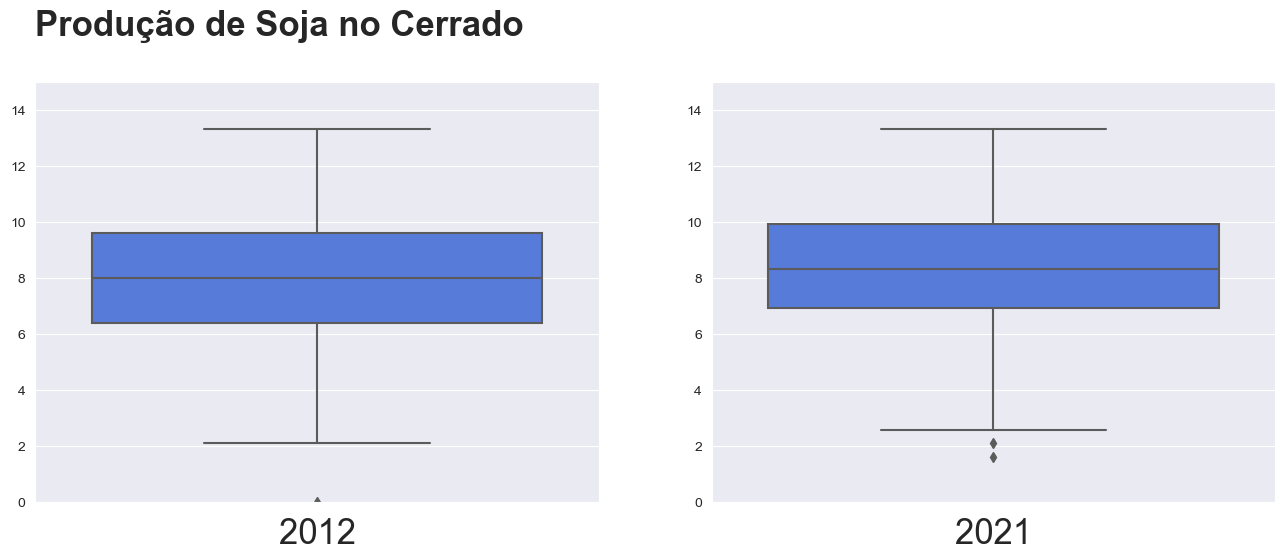

In [38]:
plt.figure(figsize=(16,12))
ax = plt.subplot(2, 2, 1)
ax = sns.boxplot(y = "Soja_5", data = soja_reajustada_2012, color='#4171EF')
ax.set_title('Produção de Soja no Cerrado \n', size=25, loc='left', weight='bold')
sns.set_palette('Accent')
sns.set_style('darkgrid')
plt.ylim(0, 15)
plt.xlabel('2012', fontsize = 25)                                                                     
plt.ylabel(None)
ax = plt.subplot(2, 2, 2)
ax = sns.boxplot(y = "Soja_6", data = soja_reajustada_2021, color='#4171EF')
ax.set_title('', size=15, loc='left', weight='bold')
sns.set_palette('Accent')
sns.set_style('darkgrid')
plt.ylim(0, 15)
plt.xlabel('2021', fontsize = 25)                                                                     
plt.ylabel(None)

In [33]:
sobreposicao_mun_cerr_anual = gpd.overlay(serie_temporal_anual, cerrado, how='intersection')

In [34]:
producao_anual = sobreposicao_mun_cerr_anual.drop(columns=['AREA_KM2','Cód.', 'Município', 'NM_MUN', 'SIGLA_UF', 'Município', 'id', 'version', 'name', 'source', 'inserted_a', 'updated_at', 'category', 'category_n', 'area_ha', 'geometry'])

In [35]:
total_2021 = producao_anual['2021'].sum()
total_2020 = producao_anual['2020'].sum()
total_2019 = producao_anual['2019'].sum()
total_2018 = producao_anual['2018'].sum()
total_2017 = producao_anual['2017'].sum()
total_2016 = producao_anual['2016'].sum()
total_2015 = producao_anual['2015'].sum()
total_2014 = producao_anual['2014'].sum()
total_2013 = producao_anual['2013'].sum()
total_2012 = producao_anual['2012'].sum()

In [36]:
serie_anual_soja_cerrado = pd.DataFrame({
    "Ano":[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
    "Soma anual":[total_2012, total_2013, total_2014, total_2015, total_2016, total_2017, total_2018, total_2019, total_2020, total_2021]
})

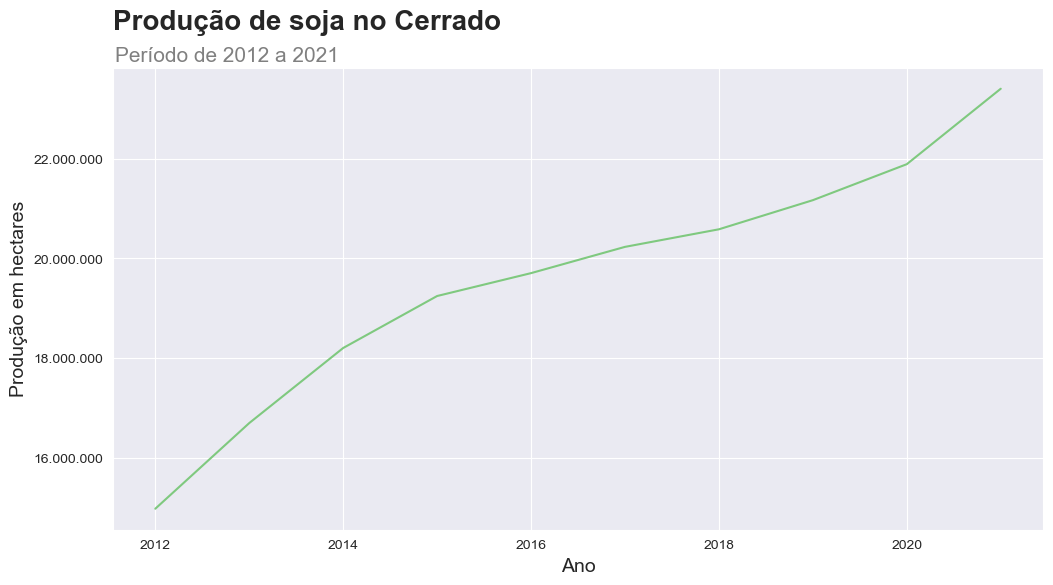

In [37]:
sns.set_palette('Accent')
sns.set_style('darkgrid')
ax = sns.lineplot(x = 'Ano', y = 'Soma anual', data=serie_anual_soja_cerrado)
ax.figure.set_size_inches(12,6)
ax.set_title('Produção de soja no Cerrado' + '\n', fontsize = 20, loc = 'left', weight='bold')
plt.suptitle('Período de 2012 a 2021', fontsize=15, y=0.915, x=0.22, color = 'Grey')
ax.set_xlabel('Ano', fontsize = 14)
ax.set_ylabel('Produção em hectares', fontsize = 14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',','.')))   
ax = ax

## Parte IV: Conclusão

### Em 2012 cerca de 7,5% do Cerrado (14.972.254 ha) estava coberto pelo cultivo de soja, mas em 2021 esse porcentagem subiu para cerca de 11,7% (23.411.119 ha), ou seja, um crescimento de  56%, sendo a soja apenas um dos tipos de cultivo existentes nesse bioma e que continua a crescer. 